Forecasting Objective
The objective of this analysis is to forecast daily city-level sales of Coconut Latte in Shanghai to support short-term operational and supply chain planning.

Forecast Scope
Forecast target: Daily Coconut Latte sales (units)
Geographic level: City (Shanghai)
Time granularity: Daily
Forecast horizon: Next 14 days
Available information: Historical sales, promotion indicators, and average temperature

Evaluation Metric
Forecast performance will be evaluated using Mean Absolute Error (MAE), which provides an intuitive interpretation in units sold and aligns with operational decision-making.


## Baseline Forecast: Rolling Average



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
sales_df = pd.read_csv(
    "data/analytics/city_daily_sales_for_forecast.csv",
    parse_dates=["date"]
)

# Focus on Shanghai
sh_df = (
    sales_df[sales_df["city"] == "Shanghai"]
    .sort_values("date")
    .copy()
)

# -----------------------------
# Train-test split
# -----------------------------
forecast_horizon = 14

train_df = sh_df.iloc[:-forecast_horizon].copy()
test_df = sh_df.iloc[-forecast_horizon:].copy()

# -----------------------------
# Rolling Average Baseline
# -----------------------------
window_size = 7

train_df.loc[:, "rolling_mean"] = (
    train_df["coconut_latte_sales"]
    .rolling(window=window_size)
    .mean()
)

# Use last rolling mean as forecast
last_rolling_mean = train_df["rolling_mean"].iloc[-1]
test_df.loc[:, "forecast"] = last_rolling_mean

# -----------------------------
# Evaluation (MAE)
# -----------------------------
mae = np.mean(
    np.abs(test_df["coconut_latte_sales"] - test_df["forecast"])
)

mae


91.31632653061226

## Regression Model with Promotion and Temperature


To improve upon the naive baseline, we introduce a regression-based model that incorporates key business drivers, including promotion indicators and average temperature.


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# -----------------------------
# Feature preparation
# -----------------------------
features = ["promotion_flag", "avg_temperature"]
target = "coconut_latte_sales"

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# -----------------------------
# Train regression model
# -----------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -----------------------------
# Forecast
# -----------------------------
test_df.loc[:, "forecast_reg"] = model.predict(X_test)

# -----------------------------
# Evaluation
# -----------------------------
mae_reg = mean_absolute_error(y_test, test_df["forecast_reg"])
mae_reg


102.34500098327707

Although promotion and temperature are significant demand drivers, the regression model underperforms the rolling average baseline. This suggests that short-term demand dynamics in Shanghai are strongly driven by recent sales history, highlighting the importance of temporal dependency in daily forecasting.


## Regression Model with Lagged Sales


To capture short-term demand dynamics, we extend the regression model by incorporating lagged sales as a proxy for recent demand level.


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# -----------------------------
# Add lagged sales feature
# -----------------------------
sh_df_lag = sh_df.copy()
sh_df_lag["lag_1_sales"] = sh_df_lag["coconut_latte_sales"].shift(1)

# Drop first row with NaN lag
sh_df_lag = sh_df_lag.dropna().reset_index(drop=True)

# Re-split train / test
forecast_horizon = 14
train_lag = sh_df_lag.iloc[:-forecast_horizon].copy()
test_lag = sh_df_lag.iloc[-forecast_horizon:].copy()

# -----------------------------
# Feature set with lag
# -----------------------------
features_lag = ["lag_1_sales", "promotion_flag", "avg_temperature"]
target = "coconut_latte_sales"

X_train = train_lag[features_lag]
y_train = train_lag[target]

X_test = test_lag[features_lag]
y_test = test_lag[target]

# -----------------------------
# Train regression model
# -----------------------------
model_lag = LinearRegression()
model_lag.fit(X_train, y_train)

# -----------------------------
# Forecast & evaluate
# -----------------------------
test_lag.loc[:, "forecast_lag"] = model_lag.predict(X_test)

mae_lag = mean_absolute_error(y_test, test_lag["forecast_lag"])
mae_lag


90.7884713275952

### Model Comparison Summary

The rolling average baseline performs strongly due to its ability to capture short-term demand dynamics.  
A regression model using only business drivers underperforms, highlighting the importance of temporal dependency in daily sales forecasting.  
By incorporating lagged sales, the regression model achieves a modest improvement over the baseline, suggesting that most short-term predictability is driven by recent demand levels, with business drivers providing incremental value.


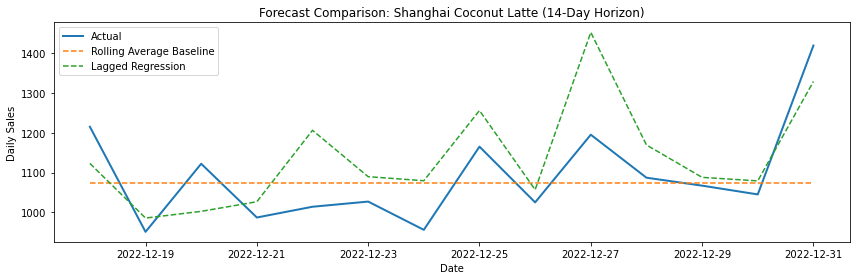

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Actual sales
plt.plot(
    test_lag["date"],
    test_lag["coconut_latte_sales"],
    label="Actual",
    linewidth=2
)

# Rolling average baseline (constant forecast)
plt.plot(
    test_lag["date"],
    test_df["forecast"],
    label="Rolling Average Baseline",
    linestyle="--"
)

# Lagged regression forecast
plt.plot(
    test_lag["date"],
    test_lag["forecast_lag"],
    label="Lagged Regression",
    linestyle="--"
)

plt.title("Forecast Comparison: Shanghai Coconut Latte (14-Day Horizon)")
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.tight_layout()
plt.show()


The rolling average baseline provides a stable reference but fails to respond to daily fluctuations.  
By incorporating lagged sales, the regression model becomes more responsive to short-term demand changes, resulting in a modest but consistent improvement in forecast accuracy.


## Forecasting Takeaways

A simple rolling average provides a strong baseline for short-term daily sales forecasting, capturing most of the predictable demand dynamics.  
Regression models relying solely on business drivers underperform, highlighting the critical role of temporal dependency.  
By incorporating lagged sales, forecast accuracy improves modestly but consistently, suggesting that recent demand history is the primary source of short-term predictability, with promotion and temperature providing incremental value.


## From Forecast Error to Perishability Risk


Daily demand forecasts directly inform raw material preparation decisions.  
For Coconut Latte, inaccurate demand forecasts can lead to over-preparation of coconut milk, which has a short shelf life.  
As a result, forecast errors may translate into material waste and increased operational risk, particularly during high-volume or promotional periods.


### Mechanism: How Forecast Error Leads to Waste

In [ ]:
-Overforecasting demand leads to excess coconut milk preparation, increasing the risk of expiration.
-Underforecasting demand leads to stockouts, negatively affecting customer experience.
-Due to the short shelf life of coconut milk, waste risk is asymmetric and primarily driven by positive forecast errors.

### Risk Amplification During Promotional Periods

Promotional periods amplify both forecast uncertainty and operational risk.
Demand during promotions is typically higher and more volatile, making forecast errors more likely.
At the same time, promotional campaigns raise customer expectations, increasing the reputational cost of stockouts.

As a result, promotional periods represent a high-risk regime where:
-Forecast errors are magnified by higher sales volume and tighter operational constraints.
-Stockouts during promotions may undermine customer trust in promotional campaigns.
-Inventory decisions require more conservative safety buffers despite increased uncertainty.